<a href="https://colab.research.google.com/github/SokichiFujita/PyTorch-for-Deep-Learning-and-Computer-Vision/blob/master/Chapter8_Convlutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import matplotlib.pyplot as plt 
import numpy as np
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
transform = transforms.Compose([transforms.Resize((28,28)),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5,),(0.5,))
                                ])
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

  0%|          | 16384/9912422 [00:00<01:30, 109893.84it/s]

9920512it [00:00, 24030717.05it/s]                           


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


32768it [00:00, 323317.31it/s]                           
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 5268606.41it/s]                           
8192it [00:00, 132908.37it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
def image_convert(tensor):
  image = tensor.cpu().clone().detach().numpy() #create numpy array from tensor
  image = image.transpose(1, 2, 0)
  print(image.shape)
  image = image * np.array((0,5,0.5,0.5)) + np.array((0,5,0.5,0.5))
  image = image.clip(0, 1)
  return image


(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


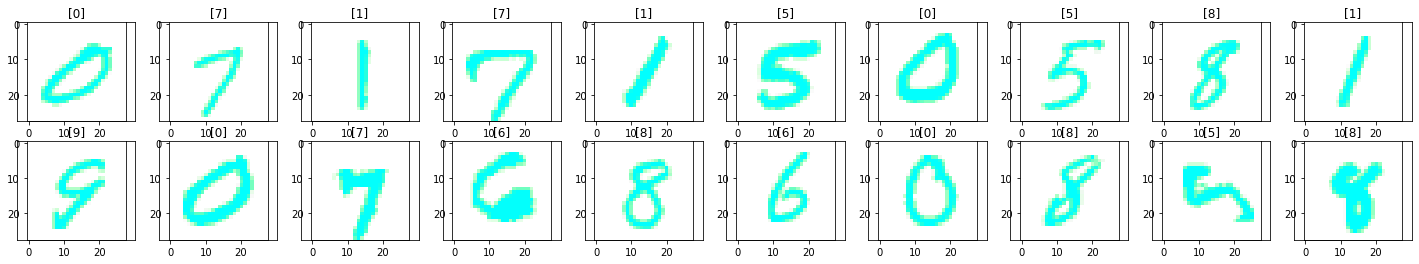

In [5]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25,4))

for i in np.arange(20):
  ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
  fig.add_subplot(2, 10, i+1)
  plt.imshow(image_convert(images[i]))
  ax.set_title([labels[i].item()])


In [0]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

In [7]:
model = LeNet().to(device)
print(model)

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [9]:
epochs = 10
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)

    print('epoch: {} training loss: {:.7f}, accuracy: {:.7f} '.format(e+1, epoch_loss, epoch_acc.item()))
    print('epoch: {} validate loss: {:.7f}, accuracy: {:.7f} '.format(e+1, val_epoch_loss, val_epoch_acc.item()))


epoch: 1 training loss: 0.5861845, accuracy: 84.4316711 
epoch: 1 validate loss: 0.1848690, accuracy: 94.7099991 
epoch: 2 training loss: 0.1565206, accuracy: 95.3166656 
epoch: 2 validate loss: 0.1112543, accuracy: 96.6599960 
epoch: 3 training loss: 0.1060580, accuracy: 96.8316727 
epoch: 3 validate loss: 0.0824014, accuracy: 97.4700012 
epoch: 4 training loss: 0.0811711, accuracy: 97.5083389 
epoch: 4 validate loss: 0.0613420, accuracy: 98.1800003 
epoch: 5 training loss: 0.0664433, accuracy: 98.0116653 
epoch: 5 validate loss: 0.0536786, accuracy: 98.3699951 
epoch: 6 training loss: 0.0579428, accuracy: 98.2550049 
epoch: 6 validate loss: 0.0459960, accuracy: 98.6199951 
epoch: 7 training loss: 0.0512607, accuracy: 98.4616699 
epoch: 7 validate loss: 0.0425509, accuracy: 98.6599960 
epoch: 8 training loss: 0.0438316, accuracy: 98.6866684 
epoch: 8 validate loss: 0.0376707, accuracy: 98.7099991 
epoch: 9 training loss: 0.0410614, accuracy: 98.7500000 
epoch: 9 validate loss: 0.03918

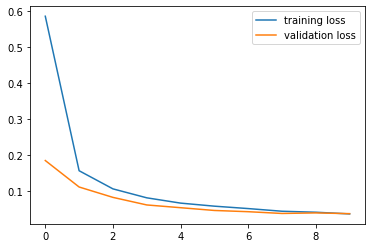

In [10]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

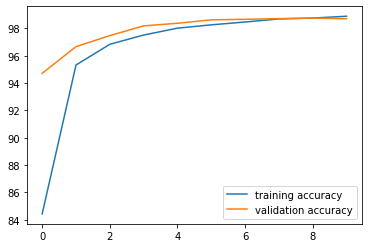

In [11]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [12]:
!pip install pillow

<Response [200]>


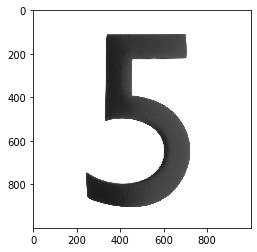

In [13]:
import requests
from PIL import Image

url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream=True)
print(response)
img = Image.open(response.raw)
plt.imshow(img)

(28, 28, 1)


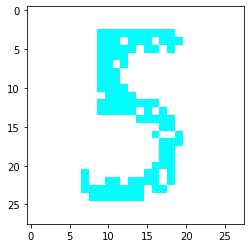

In [14]:
import PIL.ImageOps

img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img) 
plt.imshow(image_convert(img))

In [15]:
images = img.to(device)
image = images[0].unsqueeze(0).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(pred.item())

5


(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


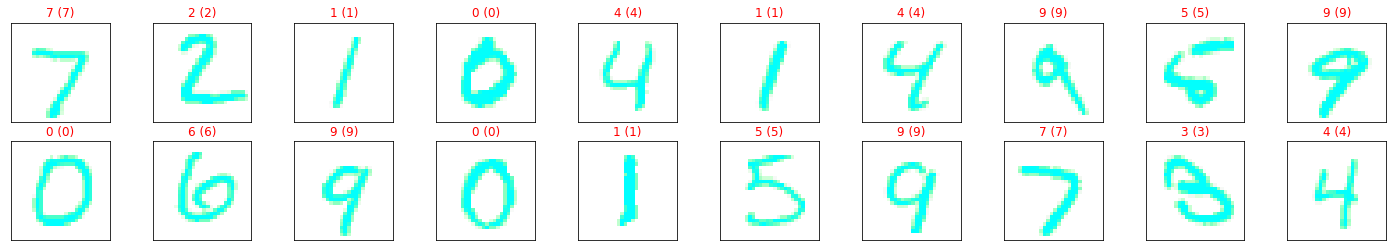

In [16]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(image_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("red" if preds[idx]==labels[idx] else "red"))